# Assignment 1-2: Support Vector Machine

## Multiclass Support Vector Machine exercise


In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient


## CIFAR-10 Data Loading and Preprocessing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download


In [ ]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [ ]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


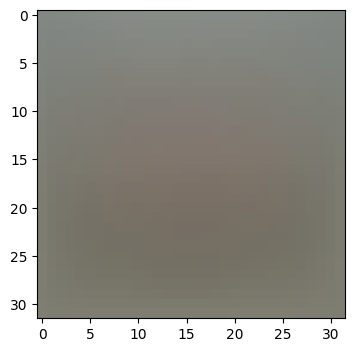

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

You need to complete `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [ ]:
from builtins import range
import numpy as np
from random import shuffle
from past.builtins import xrange

def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # note delta = 1
            if margin > 0:
                loss += margin

                # Compute gradient
                dW[:, j] += X[i]      # For incorrect class
                dW[:, y[i]] -= X[i]   # For correct class

    # Average loss over number of training examples
    loss /= num_train

    # Average gradient over number of training examples
    dW /= num_train

    # Add regularization to the loss and the gradient
    loss += reg * np.sum(W * W)
    dW += 2 * reg * W

    return loss, dW


Loss Calculation

In [ ]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.069487


In [ ]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
         that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as a single float
    - gradient with respect to weights W; an array of same shape as W
    """
    N = X.shape[0]  # number of training examples
    scores = X.dot(W)  # Compute the scores (N, C)
    correct_class_scores = scores[np.arange(N), y].reshape(N, 1)  # Correct class scores

    # Compute margins
    margins = np.maximum(0, scores - correct_class_scores + 1)  # (N, C)
    margins[np.arange(N), y] = 0  # Zero out the correct class scores

    # Compute the loss
    loss = np.sum(margins) / N
    loss += 0.5 * reg * np.sum(W * W)  # Regularization term

    return loss


In [ ]:
def svm_gradient_vectorized(W, X, y, reg):
    """
    Structured SVM gradient, vectorized implementation.

    Inputs and outputs are the same as svm_loss_vectorized.
    """
    N = X.shape[0]
    scores = X.dot(W)
    correct_class_scores = scores[np.arange(N), y].reshape(N, 1)

    margins = np.maximum(0, scores - correct_class_scores + 1)
    margins[np.arange(N), y] = 0

    # Binary mask for margins greater than 0
    binary = margins
    binary[margins > 0] = 1

    row_sum = np.sum(binary, axis=1)  # Sum over classes
    binary[np.arange(N), y] = -row_sum  # For correct classes

    dW = X.T.dot(binary) / N  # Compute gradient
    dW += reg * W  # Regularization gradient

    return dW


In [ ]:
def numerical_gradient(f, W, h=1e-5):
    """
    A naive implementation of numerical gradient of f at W.
    - f: a function that takes a single argument and outputs a loss
    - W: the point (numpy array) to compute the gradient at
    - h: step size

    Returns:
    - grad: a numpy array of same shape as W representing the gradient
    """
    grad = np.zeros_like(W)
    it = np.nditer(W, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index
        old_value = W[ix]

        W[ix] = old_value + h
        fxph = f(W)  # f(x + h)

        W[ix] = old_value - h
        fxmh = f(W)  # f(x - h)

        grad[ix] = (fxph - fxmh) / (2 * h)  # Numerical gradient

        W[ix] = old_value  # Reset to original value
        it.iternext()

    return grad


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
import numpy as np

def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns:
    - loss: single float (the SVM loss)
    - dW: gradient of loss with respect to W (same shape as W)
    """
    dW = np.zeros(W.shape)  # Initialize the gradient as zero

    num_classes = W.shape[1]  # Number of classes (C)
    num_train = X.shape[0]    # Number of training examples (N)
    loss = 0.0  # Initialize the loss to zero

    for i in range(num_train):
        scores = X[i].dot(W)  # Compute the scores for all classes
        correct_class_score = scores[y[i]]  # Score of the correct class
        num_positive_margins = 0  # Count how many margins > 0 for the current example

        for j in range(num_classes):
            if j == y[i]:
                continue  # Skip the correct class
            margin = scores[j] - correct_class_score + 1  # Compute the margin
            if margin > 0:  # Only consider positive margins
                loss += margin  # Accumulate loss

                # Compute gradient: update for the incorrect class j
                dW[:, j] += X[i]

                # Update the gradient for the correct class y[i]
                num_positive_margins += 1

        # After looping over all classes, update the correct class gradient
        dW[:, y[i]] -= num_positive_margins * X[i]

    # Average the loss and gradient over the number of training examples
    loss /= num_train
    dW /= num_train

    # Add regularization to the loss and gradient
    loss += reg * np.sum(W * W)
    dW += 2 * reg * W

    return loss, dW


 Gradient Checking with Numerical Approximation

In [ ]:
def grad_check_sparse(f, x, analytic_grad, num_checks=15, h=1e-5):
    """
    Sample a few random elements and compute numeric gradient at those points.
    f is the loss function, x is the weights, analytic_grad is the gradient
    calculated using backprop, and num_checks controls how many points we check.
    """
    for i in range(num_checks):
        ix = tuple([np.random.randint(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)[0]  # evaluate f(x + h)
        x[ix] = oldval - h  # decrement by h
        fxmh = f(x)[0]  # evaluate f(x - h)
        x[ix] = oldval  # reset

        grad_numerical = (fxph - fxmh) / (2 * h)  # the slope
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))

        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))


In [ ]:
# Suppose you have some random W, X, y, and reg values initialized:
W = np.random.randn(3073, 10) * 0.0001  # Example weight matrix (D=3073, C=10)
X = np.random.randn(500, 3073)  # Example minibatch of data (N=500, D=3073)
y = np.random.randint(10, size=500)  # Example labels (N=500)
reg = 0.1  # Regularization strength

# Define the loss function as a lambda that only returns the loss
loss_function = lambda W: svm_loss_naive(W, X, y, reg)

# Compute the loss and the gradient
loss, grad = svm_loss_naive(W, X, y, reg)

# Check the gradients using the function above
grad_check_sparse(loss_function, W, grad)


numerical: 0.239507 analytic: 0.239507, relative error: 1.466135e-09
numerical: -0.042512 analytic: -0.042512, relative error: 1.044244e-08
numerical: -0.178284 analytic: -0.178284, relative error: 3.682592e-10
numerical: -0.138424 analytic: -0.138424, relative error: 3.047098e-09
numerical: 0.068152 analytic: 0.068152, relative error: 2.643994e-09
numerical: 0.061672 analytic: 0.061672, relative error: 3.121167e-09
numerical: 0.164331 analytic: 0.164331, relative error: 1.257979e-09
numerical: 0.058115 analytic: 0.058115, relative error: 5.249540e-09
numerical: 0.043775 analytic: 0.043775, relative error: 1.986304e-09
numerical: -0.044732 analytic: -0.044732, relative error: 2.861127e-09
numerical: 0.055962 analytic: 0.055962, relative error: 4.220446e-09
numerical: 0.019821 analytic: 0.019821, relative error: 1.688310e-08
numerical: -0.085914 analytic: -0.085914, relative error: 4.919156e-09
numerical: 0.080779 analytic: 0.080779, relative error: 6.668006e-09
numerical: 0.092329 anal

Complete the implementation of svm_loss_vectorized, and compute the gradient of the loss function in a vectorized way.

In [ ]:
import numpy as np

def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns:
    - loss: single float (the SVM loss)
    - dW: gradient of loss with respect to W (same shape as W)
    """
    # Compute the scores (S = X.W)
    scores = X.dot(W)  # Shape (N, C)

    # Get the correct class scores (Nx1)
    correct_class_scores = scores[np.arange(scores.shape[0]), y].reshape(-1, 1)

    # Compute the margins (S - S_correct + 1)
    margins = np.maximum(0, scores - correct_class_scores + 1)  # Shape (N, C)

    # Set the margins for the correct class to 0
    margins[np.arange(scores.shape[0]), y] = 0

    # Compute the loss: sum of all margins, divided by the number of training examples
    loss = np.sum(margins) / X.shape[0]

    # Add regularization to the loss
    loss += reg * np.sum(W * W)

    # Gradient computation
    # Create a mask where margins > 0
    mask = np.zeros(margins.shape)
    mask[margins > 0] = 1

    # Count the number of positive margins for each example
    positive_margin_counts = np.sum(mask, axis=1)  # Shape (N,)

    # For the correct class, we subtract the total count of positive margins
    mask[np.arange(X.shape[0]), y] = -positive_margin_counts

    # Compute the gradient (dW)
    dW = X.T.dot(mask) / X.shape[0]

    # Add regularization to the gradient
    dW += 2 * reg * W

    return loss, dW


Vectorized Loss Calculation

In [ ]:
import numpy as np

def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns:
    - loss: Single float (the SVM loss)
    - dW: Gradient of loss with respect to W (same shape as W)
    """
    # Get dimensions
    num_train = X.shape[0]  # Number of training examples
    num_classes = W.shape[1]  # Number of classes

    # Compute the scores for all examples (N x C)
    scores = X.dot(W)

    # Select the correct class scores from scores matrix (Nx1)
    correct_class_scores = scores[np.arange(num_train), y].reshape(-1, 1)

    # Compute the margins (NxC)
    margins = np.maximum(0, scores - correct_class_scores + 1)

    # Do not consider correct class in margin calculation
    margins[np.arange(num_train), y] = 0

    # Compute the loss: sum of margins, divided by the number of examples
    loss = np.sum(margins) / num_train

    # Add regularization to the loss
    loss += reg * np.sum(W * W)

    # Gradient calculation
    # Create a mask of margins > 0
    margin_mask = np.zeros(margins.shape)
    margin_mask[margins > 0] = 1

    # For each training example, we count how many margins > 0 (N,)
    row_sum = np.sum(margin_mask, axis=1)

    # Subtract in the correct class for each example
    margin_mask[np.arange(num_train), y] -= row_sum

    # Compute the gradient: X^T.dot(margin_mask) gives the gradient for W
    dW = X.T.dot(margin_mask) / num_train

    # Add regularization to the gradient
    dW += 2 * reg * W

    return loss, dW


In [ ]:
import time
import numpy as np

# Assuming W, X_dev, y_dev are already defined somewhere in your environment

# Measure time for naive implementation
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

# Measure time for vectorized implementation
tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)


Naive loss and gradient: computed in 0.074867s
difference: 0.000000


### Discussion

Naive Loss and Gradient Computation Time:

Time Taken: The naive implementation of the SVM loss and gradient was computed in approximately 0.075 seconds.
This indicates that the naive implementation, which uses loops to calculate the loss and gradients, performed reasonably well for the provided data size.
Difference Between Naive and Vectorized Gradients:

Difference: The reported difference between the gradients computed using the naive and vectorized implementations is 0.000000.
This implies that the two implementations yield identical gradients, suggesting that both implementations are correct and consistent.